In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

"Pradhan Mantri Jan-Dhan Yojana (PMJDY)" under the National Mission for Financial Inclusion was launched initially for a period of 4 years (in two phases) on 28th August 2014. It envisages universal access to banking facilities with at least one basic banking account for every household, financial literacy, access to credit, insurance and pension.


PMJDY has provided a platform for the three social security schemes viz. Pradhan Mantri Jeevan Jyoti Bima Yojana (PMJJBY), Pradhan Mantri Suraksha Bima Yojana (PMSBY), Atal Pension Yojana (APY) and Pradhan Mantri Mudra Yojana (PMMY).

In [13]:
data = pd.read_csv('../data/imf.csv',index_col=0,encoding = "utf-8")

In [14]:
print(list(data.columns))

['Year', 'ISO-3 code', 'Institutions of commercial banks', 'Number of credit unions and credit cooperatives', 'Number of deposit-taking microfinance institutions', 'Number of other deposit takers', 'Number of non-deposit taking microfinance institutions', 'Number of insurance corporations', 'Branches of commercial banks', 'Branches of credit unions and credit cooperatives', 'Branches of deposit taking MFIs', 'Branches of other deposit takers', 'Branches of non-deposit taking microfinance institutions', 'Number of non-branch retail agent outlets of commercial banks', 'Automated Teller Machines (ATMs)', 'Number of registered mobile money agent outlets', 'Number of active mobile money agent outlets', 'Depositors with commercial banks', 'Depositors with commercial banks: o/w SME', 'Depositors with commercial banks: o/w household sector', 'Depositors with commercial banks: o/w household: o/w male', 'Depositors with commercial banks: o/w household: o/w female', 'Depositors with credit unions

# Synthetic Control w/ Lasso

In [15]:
import sklearn.linear_model as lm
import sklearn.ensemble as en

In [16]:
# time_intervention = 2016
# target = 'India'
# series = 'Non-life insurance policies per 1,000 adults'
# donors = ['Myanmar','Portugal','Hungary','Mexico','Turkey','Bangladesh']
def setup(target,donors,series,time_intervention,data):
    Y_target = pd.DataFrame(data.loc[target,series].to_numpy(),index=data['Year'].unique(),columns=[target])
    Y_donor = (pd.DataFrame([data.loc[donor,series].to_numpy() for donor in donors],index=donors,columns=data['Year'].unique()).T).dropna(axis=1)#.fillna(method='ffill').fillna(method='bfill')
    Ypre_target = Y_target.loc[Y_target.index<=time_intervention] #pre_intervention.loc[target,series].fillna(method='ffill').fillna(method='bfill').to_numpy()
    Ypre_donor = Y_donor.loc[Y_donor.index<=time_intervention] #(pd.DataFrame([pre_intervention.loc[donor,series].to_numpy() for donor in donors],index=donors).T).fillna(method='ffill').fillna(method='bfill')
    return Ypre_target,Ypre_donor,Y_target,Y_donor

# Bundles

In [17]:
bundles_names = ['Deposit accounts with commercial banks: o/w household sector',
                 'No of household sector deposit accounts with commercial banks per 1,000 adults',
                 'Number of life insurance policies per 1,000 adults',
                 'Non-life insurance policies per 1,000 adults',
                 'Number of loan accounts with commercial banks per 1,000 adults',
                 'Loan accounts with commercial banks: o/w SME',
                 'No of household sector loan accounts with commercial banks per 1,000 adults',
                 'Number of borrowers from credit unions and credit cooperatives per 1,000 adults']


In [18]:
bundles = {}
for series in bundles_names:
    time_intervention = 2015
    target = 'India'
    donors = [ 'Argentina', 'Armenia, Rep. of', 'Bangladesh', 'Barbados', 'Belarus, Rep. of', 'Bhutan', 'Bosnia and Herzegovina', 'Botswana', 
              'Brunei Darussalam', 'Cambodia', 'Cameroon', 'Chile', 'China, P.R.: Macao', 'China, P.R.: Mainland', 'Colombia', 'Costa Rica', 'Cyprus', 
              'Egypt, Arab Rep. of', 'Fiji, Rep. of', 'Georgia', 'Guinea', 'Honduras', 'Hungary', 'Jamaica', 'Japan', 'Jordan', 
              'Kazakhstan, Rep. of', 'Korea, Rep. of', 'Kosovo, Rep. of', "Lao People's Dem. Rep.", 'Latvia', 'Lebanon', 'Lesotho, Kingdom of', 
              'Maldives', 'Mauritius', 'Mexico', 'Moldova, Rep. of', 'Montenegro', 'Myanmar', 'Nicaragua', 'North Macedonia, Republic of', 'Pakistan', 
              'Poland, Rep. of', 'Portugal', 'Romania', 'Russian Federation', 'Rwanda', 'Samoa', 'São Tomé and Príncipe, Dem. Rep. of', 'Saudi Arabia', 
              'Serbia, Rep. of', 'Seychelles', 'Slovak Rep.', 'Suriname', 'Thailand', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Ukraine', 'Vanuatu', 
              'Zambia']
    Ypre_target,Ypre_donor,Y_target,Y_donor = setup(target,donors,series,time_intervention,data)
    bundles[series] = (Ypre_target,Ypre_donor,Y_target,Y_donor)

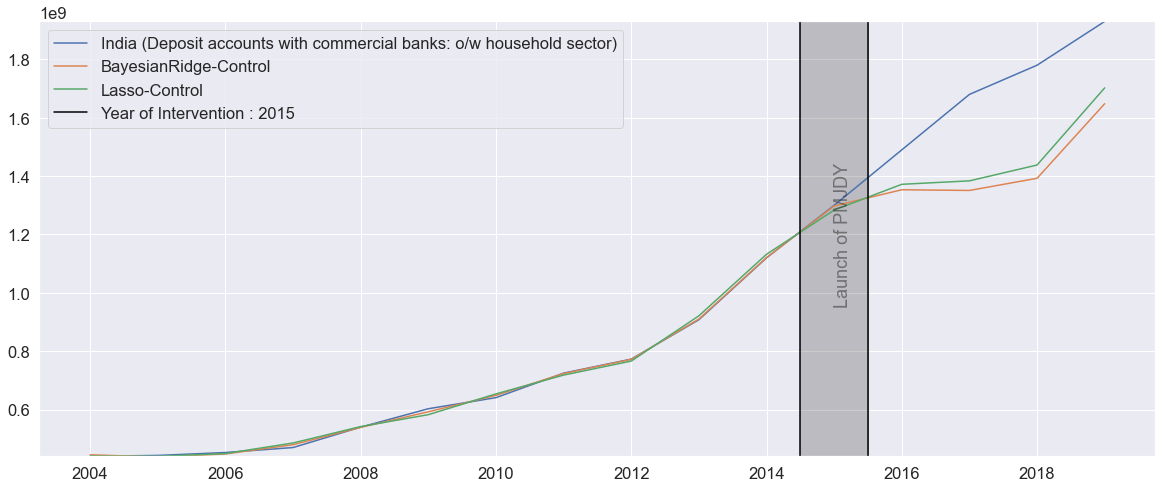

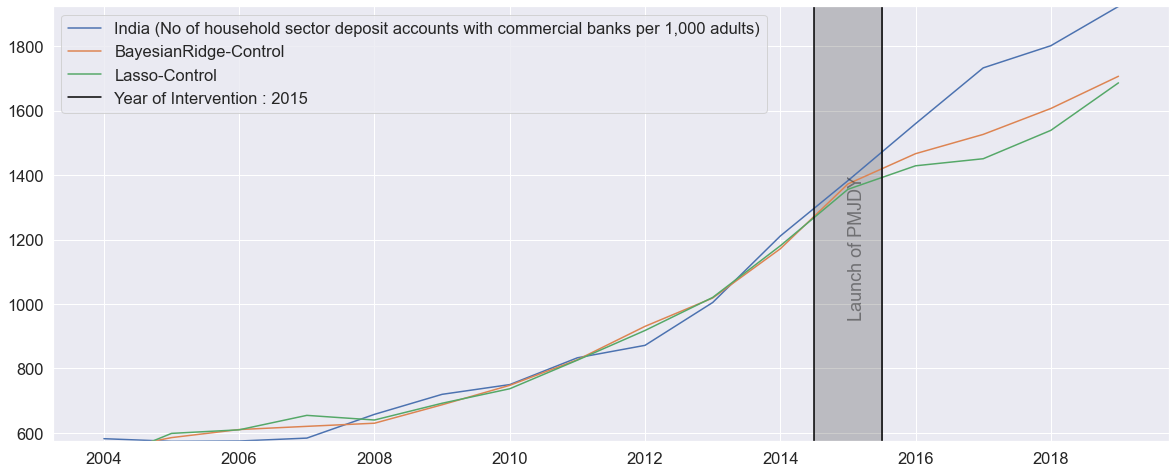

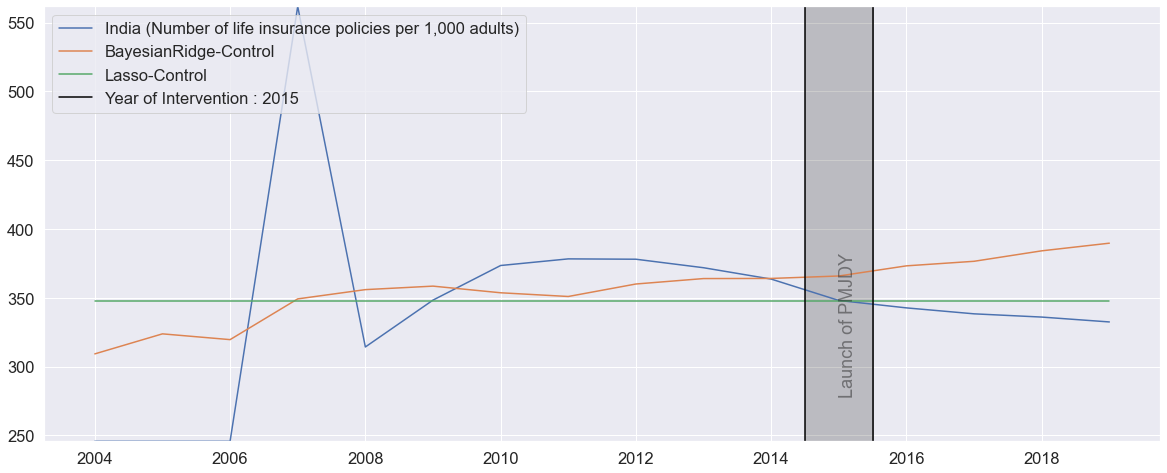

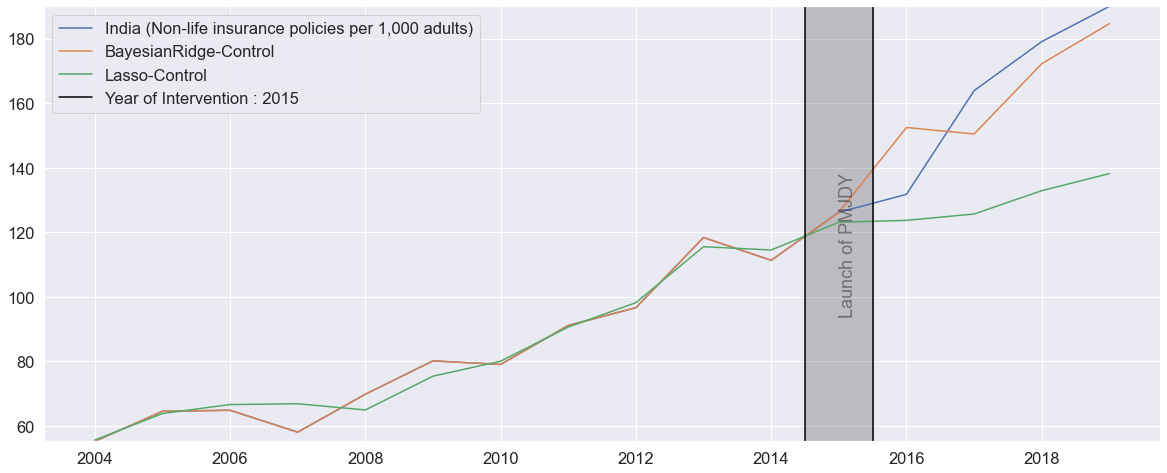

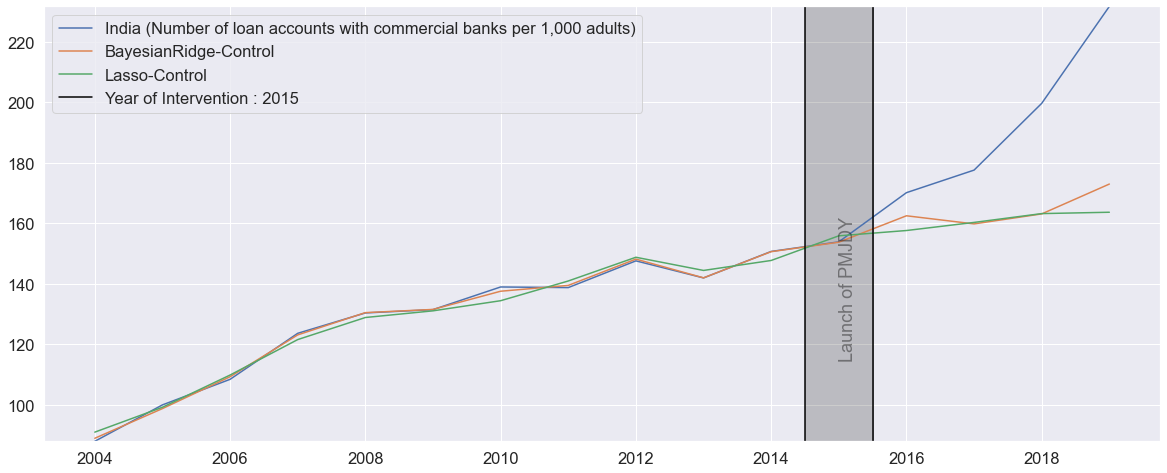

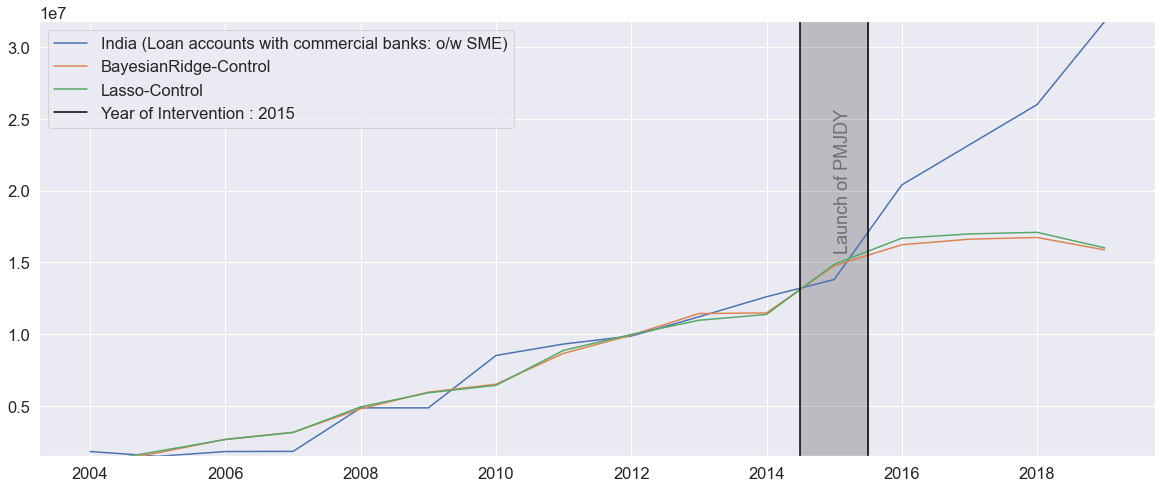

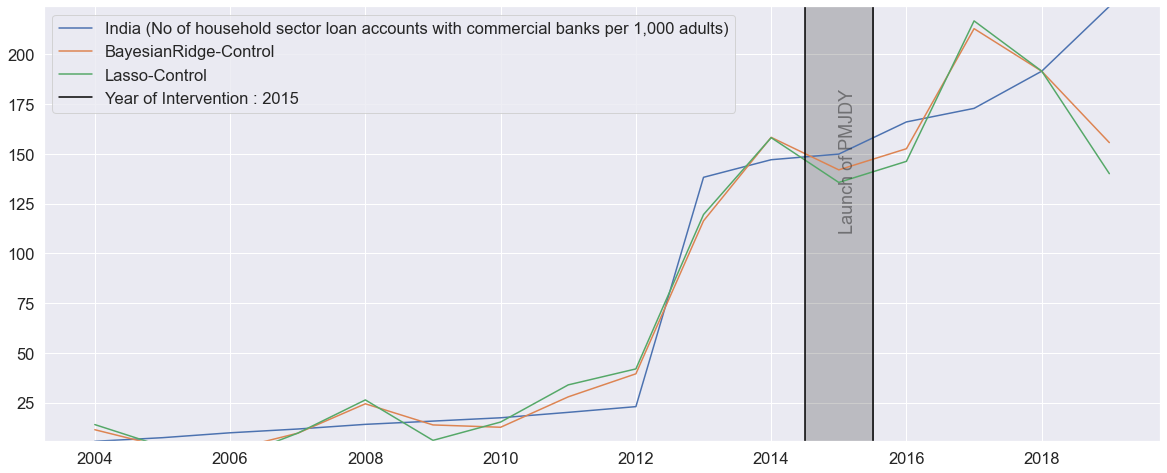

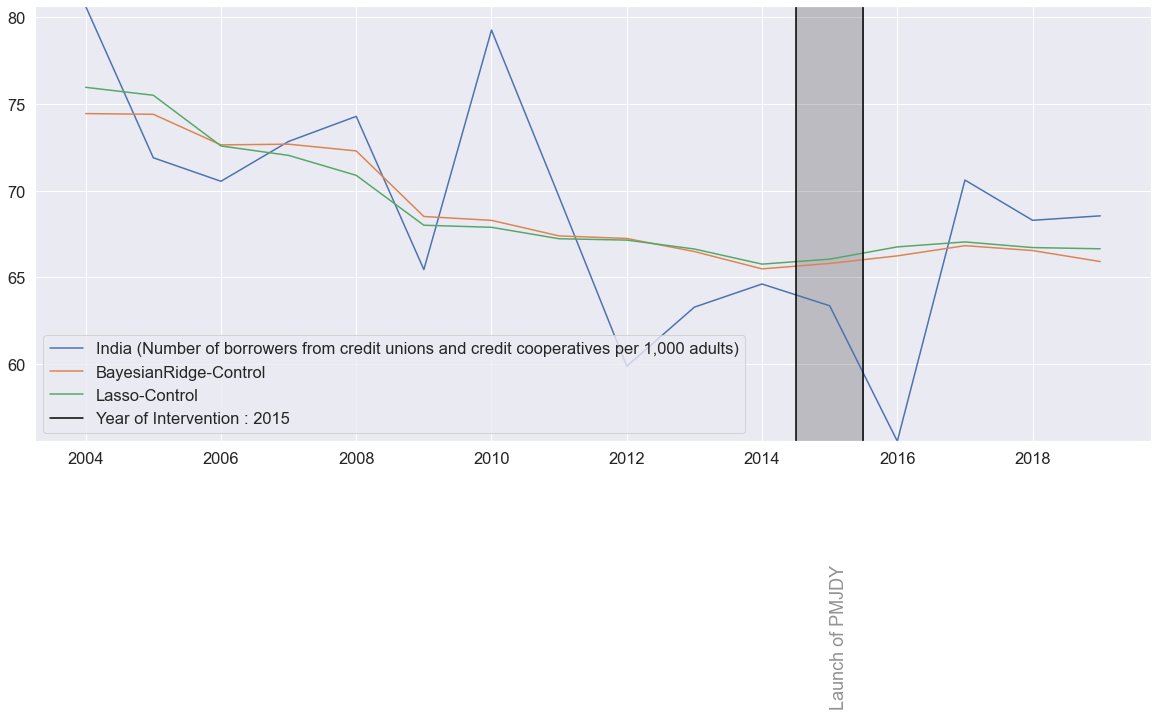

In [21]:
for series in bundles.keys():
    (Ypre_target,Ypre_donor,Y_target,Y_donor) = bundles[series]
    
    m_lasso = lm.LassoCV().fit(Ypre_donor,Ypre_target)
    m_bayesian = lm.BayesianRidge().fit(Ypre_donor,Ypre_target)
#     m_rf = en.RandomForestRegressor().fit(Ypre_donor,Ypre_target)
    
    Y_target_lasso = m_lasso.predict(Y_donor.fillna(method='ffill'))
    Y_target_bayesian,std_y_target_bayesian = m_bayesian.predict(Y_donor.fillna(method='ffill'),return_std=True)
#     Y_target_rf = m_rf.predict(Y_donor.fillna(method='ffill'))
    
    fig = plt.figure(figsize=(20,8))
    sns.set(font_scale=1.5)
    plt.plot(np.arange(2004,2020),Y_target)
    plt.plot(np.arange(2004,2020),Y_target_bayesian)
    plt.plot(np.arange(2004,2020),Y_target_lasso)
#     plt.plot(np.arange(2004,2020),Y_target_rf)
    plt.axvline(time_intervention-0.5,c='black')
    plt.axvline(time_intervention+0.5,c='black')
    plt.fill_betweenx(y=Y_target.sort_values(by='India').to_numpy()[:,0],
                      x1=np.ones_like(Y_target.to_numpy()[:,0])*(time_intervention-0.5),
                      x2=np.ones_like(Y_target.to_numpy()[:,0])*(time_intervention+0.5),alpha=0.2,color='black')
    plt.text(2015,np.max(Y_target.to_numpy())/2,'Launch of PMJDY',rotation=90,alpha=0.5)
    plt.ylim((np.min(Y_target.to_numpy()),np.max(Y_target.to_numpy())))
    plt.legend(['%s (%s)'%(target,series),'BayesianRidge-Control','Lasso-Control','Year of Intervention : 2015'])
    fig.savefig('%s_%s.png'%(target,series.replace('/','')))

In [20]:
np.min(Y_target)

India    55.53889
dtype: float64